In [4]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
def load_images_to_dataframe(dataset_dir, target_size=(68, 68)):
    data = []
    labels = []

    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Load gambar dan ubah ukuran
                    img = load_img(img_path, target_size=target_size, color_mode="grayscale")
                    img_array = img_to_array(img) / 255.0  # Normalisasi nilai pixel
                    
                    # Cek apakah gambar hitam sepenuhnya
                    if np.all(img_array == 0):
                        print(f"Menghapus gambar hitam: {img_path}")
                        continue  # Lewati gambar hitam
                    
                    data.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Konversi ke DataFrame
    df = pd.DataFrame({
        "image": data,
        "label": labels
    })
    return df

In [26]:
test = r"E:\AI_Projek\Stress no stress\KDEF\KDEF\Test"
train = r"E:\AI_Projek\Stress no stress\KDEF\KDEF\Train"
df_tr = load_images_to_dataframe(train)
df_te = load_images_to_dataframe(test)

In [27]:
import matplotlib.pyplot as plt

def plot_sample_images(df, num_samples=5):
    """
    Plot beberapa sampel gambar dari DataFrame.
    
    Args:
    - df: DataFrame dengan kolom "image" (numpy array) dan "label".
    - num_samples: Jumlah gambar yang ingin diplot.
    """
    plt.figure(figsize=(10, 5))  # Ukuran plot
    for i in range(min(num_samples, len(df))):  # Pastikan tidak melebihi jumlah gambar
        image = df.iloc[i]["image"]  # Ambil gambar
        label = df.iloc[i]["label"]  # Ambil label
        plt.subplot(1, num_samples, i + 1)  # Subplot grid
        plt.imshow(image.squeeze(), cmap="gray")  # Squeeze untuk gambar grayscale
        plt.title(label)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


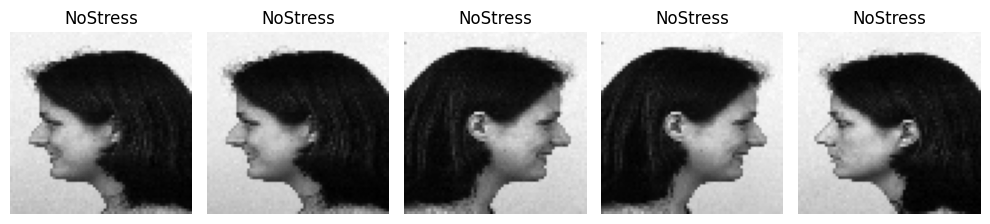

In [28]:
k = plot_sample_images(df_tr)

In [29]:
l = df_tr['label'].unique()
l

array(['NoStress', 'Stress'], dtype=object)

In [30]:
label_map = {'NoStress': 0, 'Stress': 1}
df_tr['label'] = df_tr['label'].map(label_map)
df_te['label'] = df_te['label'].map(label_map)

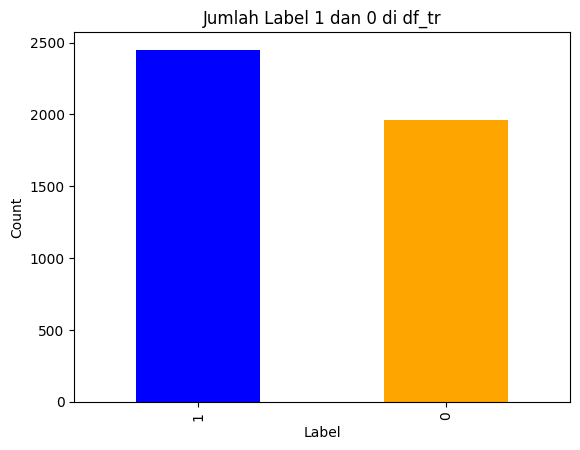

In [32]:
df_tr['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Jumlah Label 1 dan 0 di df_tr')
plt.show()

In [34]:
# Separate majority and minority classes
df_majority = df_tr[df_tr.label == 0]
df_minority = df_tr[df_tr.label == 1]

# Ensure that the minority class is not larger than the majority class
if len(df_minority) > len(df_majority):
	df_majority, df_minority = df_minority, df_majority

# Undersample majority class
df_majority_undersampled = df_majority.sample(len(df_minority))

# Combine minority class with undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the dataframe
df_undersampled = df_undersampled.sample(frac=1).reset_index(drop=True)

df_undersampled['label'].value_counts()

label
0    1960
1    1960
Name: count, dtype: int64

In [35]:
X_tr = np.stack(df_tr['image'].values)  # Konversi daftar array gambar ke numpy array
y_tr = to_categorical(df_tr['label'].values) 

In [36]:
import tensorflow as tf
model = Sequential([
    Conv2D(18, (3, 3), activation='relu', input_shape=(68, 68, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y_tr.shape[1], activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
pred = model.fit(X_tr, y_tr, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5559 - loss: 0.6738 - val_accuracy: 0.0023 - val_loss: 0.9131
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5595 - loss: 0.6439 - val_accuracy: 0.3946 - val_loss: 0.7873
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6998 - loss: 0.5557 - val_accuracy: 0.7596 - val_loss: 0.6308
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7041 - loss: 0.5271 - val_accuracy: 0.7279 - val_loss: 0.6569
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7212 - loss: 0.5001 - val_accuracy: 0.8107 - val_loss: 0.5909
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7373 - loss: 0.4966 - val_accuracy: 0.8469 - val_loss: 0.5420
Epoch 7/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7250 - loss: 0.4818 - val_accuracy: 0.6735 - val_loss: 0.6908
Epoch 8/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7488 - loss: 0.4699 - val_accu

In [38]:
X_te = np.stack(df_te['image'].values)  # Konversi daftar array gambar ke numpy array
y_te = to_categorical(df_te['label'].values)

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
y_pred = model.predict(X_te)
y_pred_binary = (y_pred > 0.5).astype(int) 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [41]:
accuracy = accuracy_score(y_te, y_pred_binary)
print(f"Akurasi pada data test: {accuracy * 100:.2f}%")

Akurasi pada data test: 75.62%


In [42]:
from sklearn.metrics import f1_score, classification_report

In [43]:
report = classification_report(y_te, y_pred_binary, target_names=['NoStress', 'Stress'])
print(report)

              precision    recall  f1-score   support

    NoStress       0.80      0.76      0.78       842
      Stress       0.77      0.95      0.85      1049

   micro avg       0.78      0.87      0.82      1891
   macro avg       0.78      0.85      0.81      1891
weighted avg       0.78      0.87      0.82      1891
 samples avg       0.81      0.87      0.83      1891



In [44]:
model.save('model1.h5')